In [72]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [111]:
datasets = {
            'rna': '../data/gbm/GBM_RNASeq.csv',
            'mirna': '../data/gbm/GBM_miRNA.csv',
            'methylation': '../data/gbm/GBM_Methylation.csv',
}
        
labels = '../data/gbm/GBM_Clinical.csv'

In [7]:
survival = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0).astype(float)
    print(modality, data[modality].shape)

rna (477, 20118)
mirna (477, 791)
methylation (477, 20114)


# Survival Prediction

## Preprocessing

### Removing low-variance + null features

In [1]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    return X_new

In [3]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality], percentage=0.05)
    print(modality, new_data[modality].shape)

NameError: name 'data' is not defined

In [10]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in data:
    X[modality] = pd.DataFrame(data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (477, 20118)
mirna (477, 791)
methylation (477, 18137)


In [71]:
# Create 2 evenly spaced bins
labels = ["low", "high"]
s_cut = pd.qcut(survival['overall_survival'], q=2, labels=labels)
print(f"Median: {survival['overall_survival'].median()}")
s_cut.value_counts()

Median: 736.0


low     239
high    238
Name: overall_survival, dtype: int64

In [15]:
enc = LabelEncoder()
y = enc.fit_transform(s_cut)
enc.inverse_transform([0, 1])

array(['high', 'low'], dtype=object)

## Base Learners

In [73]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

In [74]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (low)': make_scorer(recall_multiclass, label=1), 'recall (high)': make_scorer(recall_multiclass, label=0)})

 25%|██▌       | 1/4 [00:14<00:44, 14.92s/it]

logistic                  accuracy balanced_accuracy               f1     recall (low)  \
logistic  0.627 +/- 0.017   0.627 +/- 0.017  0.627 +/- 0.017  0.611 +/- 0.033   

            recall (high)  
logistic  0.643 +/- 0.016  


 50%|█████     | 2/4 [00:39<00:41, 20.85s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.612 +/- 0.042   0.612 +/- 0.042  0.610 +/- 0.044   

                           recall (low)    recall (high)  
balanced_random_forest  0.557 +/- 0.081  0.668 +/- 0.039  


 75%|███████▌  | 3/4 [01:20<00:29, 29.96s/it]

deep_nn                 accuracy balanced_accuracy               f1     recall (low)  \
deep_nn  0.591 +/- 0.022   0.591 +/- 0.022  0.590 +/- 0.023  0.615 +/- 0.040   

           recall (high)  
deep_nn  0.567 +/- 0.062  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1     recall (low)  \
svc  0.625 +/- 0.015   0.625 +/- 0.015  0.625 +/- 0.015  0.615 +/- 0.018   

       recall (high)  
svc  0.634 +/- 0.026  


 25%|██▌       | 1/4 [00:00<00:01,  1.64it/s]

logistic                  accuracy balanced_accuracy               f1     recall (low)  \
logistic  0.533 +/- 0.058   0.533 +/- 0.058  0.532 +/- 0.058  0.519 +/- 0.052   

            recall (high)  
logistic  0.547 +/- 0.071  


 50%|█████     | 2/4 [00:02<00:02,  1.40s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.564 +/- 0.081   0.564 +/- 0.080  0.561 +/- 0.085   

                           recall (low)    recall (high)  
balanced_random_forest  0.531 +/- 0.149  0.597 +/- 0.031  


 75%|███████▌  | 3/4 [00:08<00:03,  3.57s/it]

deep_nn                 accuracy balanced_accuracy               f1     recall (low)  \
deep_nn  0.566 +/- 0.024   0.566 +/- 0.024  0.566 +/- 0.024  0.548 +/- 0.024   

           recall (high)  
deep_nn  0.584 +/- 0.034  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1     recall (low)  \
svc  0.528 +/- 0.061   0.529 +/- 0.061  0.528 +/- 0.061  0.514 +/- 0.055   

       recall (high)  
svc  0.543 +/- 0.079  


 25%|██▌       | 1/4 [00:10<00:31, 10.53s/it]

logistic                  accuracy balanced_accuracy               f1     recall (low)  \
logistic  0.614 +/- 0.055   0.615 +/- 0.056  0.613 +/- 0.055  0.577 +/- 0.051   

            recall (high)  
logistic  0.652 +/- 0.077  


 50%|█████     | 2/4 [00:35<00:37, 18.90s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.623 +/- 0.036   0.623 +/- 0.036  0.621 +/- 0.035   

                           recall (low)    recall (high)  
balanced_random_forest  0.569 +/- 0.033  0.677 +/- 0.052  


 75%|███████▌  | 3/4 [01:16<00:29, 29.26s/it]

deep_nn                 accuracy balanced_accuracy               f1     recall (low)  \
deep_nn  0.616 +/- 0.052   0.616 +/- 0.052  0.615 +/- 0.052  0.586 +/- 0.051   

           recall (high)  
deep_nn  0.647 +/- 0.079  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1     recall (low)  \
svc  0.614 +/- 0.050   0.615 +/- 0.050  0.613 +/- 0.050  0.573 +/- 0.051   

       recall (high)  
svc  0.656 +/- 0.076  


In [75]:
display(base_metrics_df['rna']), display(base_metrics_df['mirna']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (low),recall (high)
logistic,0.627 +/- 0.017,0.627 +/- 0.017,0.627 +/- 0.017,0.611 +/- 0.033,0.643 +/- 0.016
balanced_random_forest,0.612 +/- 0.042,0.612 +/- 0.042,0.610 +/- 0.044,0.557 +/- 0.081,0.668 +/- 0.039
deep_nn,0.591 +/- 0.022,0.591 +/- 0.022,0.590 +/- 0.023,0.615 +/- 0.040,0.567 +/- 0.062
svc,0.625 +/- 0.015,0.625 +/- 0.015,0.625 +/- 0.015,0.615 +/- 0.018,0.634 +/- 0.026


,accuracy,balanced_accuracy,f1,recall (low),recall (high)
logistic,0.533 +/- 0.058,0.533 +/- 0.058,0.532 +/- 0.058,0.519 +/- 0.052,0.547 +/- 0.071
balanced_random_forest,0.564 +/- 0.081,0.564 +/- 0.080,0.561 +/- 0.085,0.531 +/- 0.149,0.597 +/- 0.031
deep_nn,0.566 +/- 0.024,0.566 +/- 0.024,0.566 +/- 0.024,0.548 +/- 0.024,0.584 +/- 0.034
svc,0.528 +/- 0.061,0.529 +/- 0.061,0.528 +/- 0.061,0.514 +/- 0.055,0.543 +/- 0.079


,accuracy,balanced_accuracy,f1,recall (low),recall (high)
logistic,0.614 +/- 0.055,0.615 +/- 0.056,0.613 +/- 0.055,0.577 +/- 0.051,0.652 +/- 0.077
balanced_random_forest,0.623 +/- 0.036,0.623 +/- 0.036,0.621 +/- 0.035,0.569 +/- 0.033,0.677 +/- 0.052
deep_nn,0.616 +/- 0.052,0.616 +/- 0.052,0.615 +/- 0.052,0.586 +/- 0.051,0.647 +/- 0.079
svc,0.614 +/- 0.050,0.615 +/- 0.050,0.613 +/- 0.050,0.573 +/- 0.051,0.656 +/- 0.076


(None, None, None)

In [76]:
estimator_names = [estimator[0] for estimator in estimators]

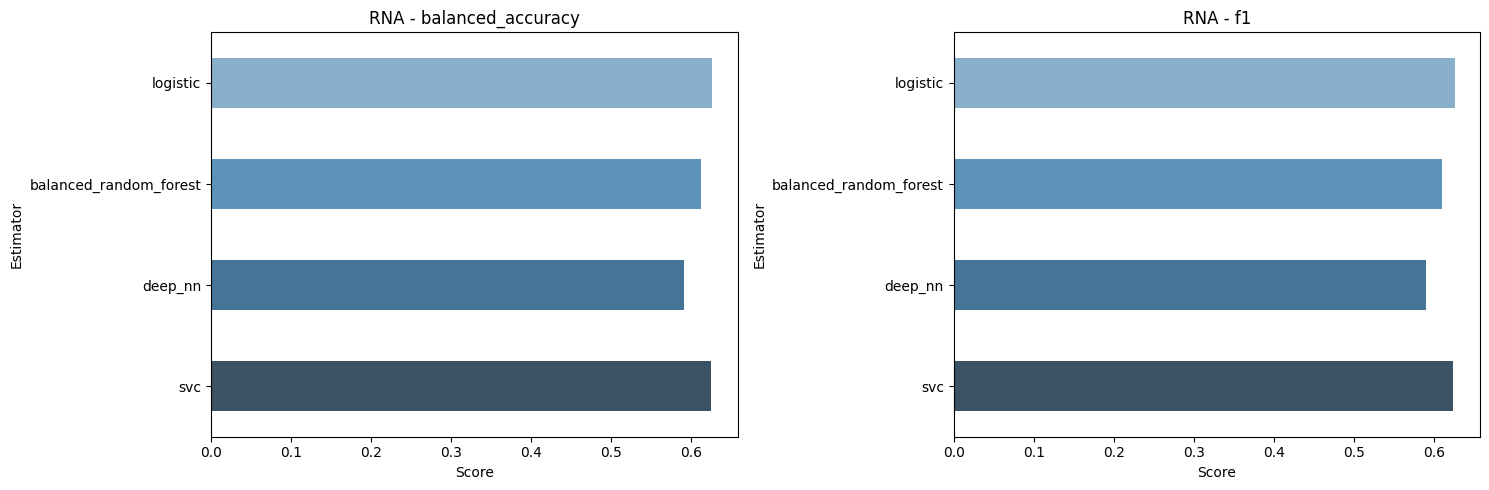

In [77]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

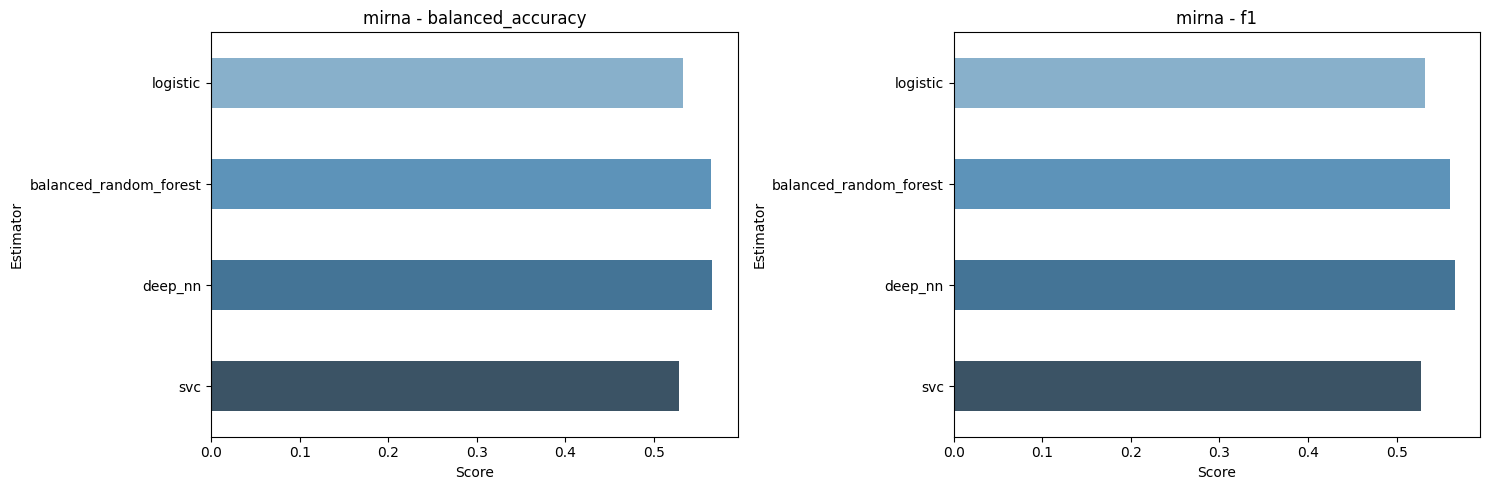

In [78]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'mirna', metrics=['balanced_accuracy', 'f1'])

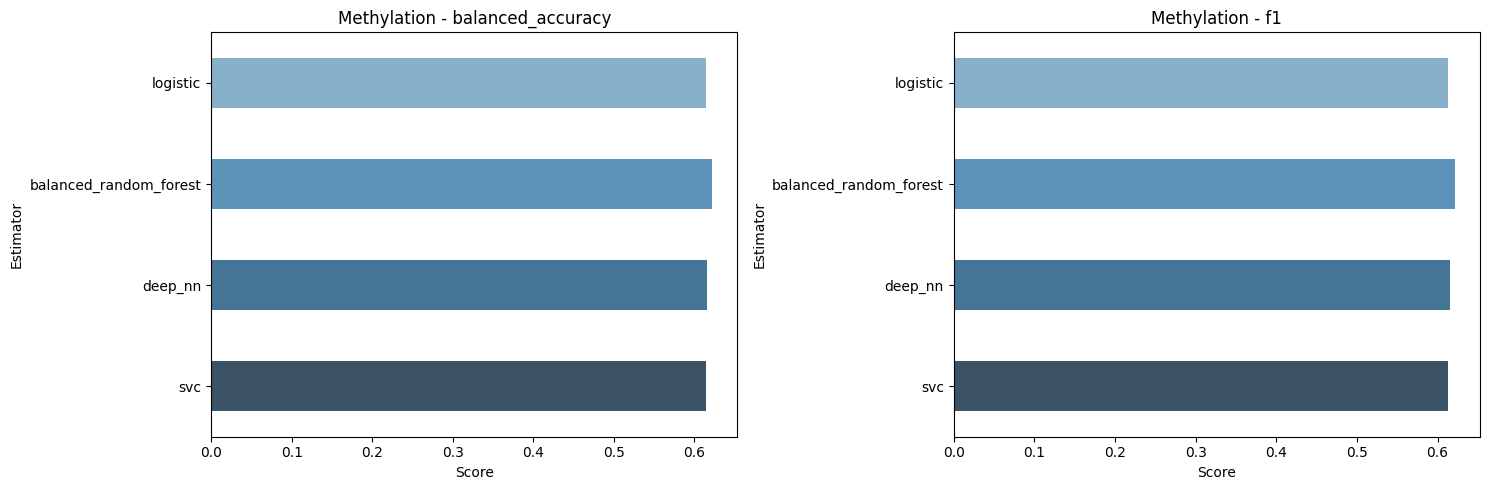

In [79]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

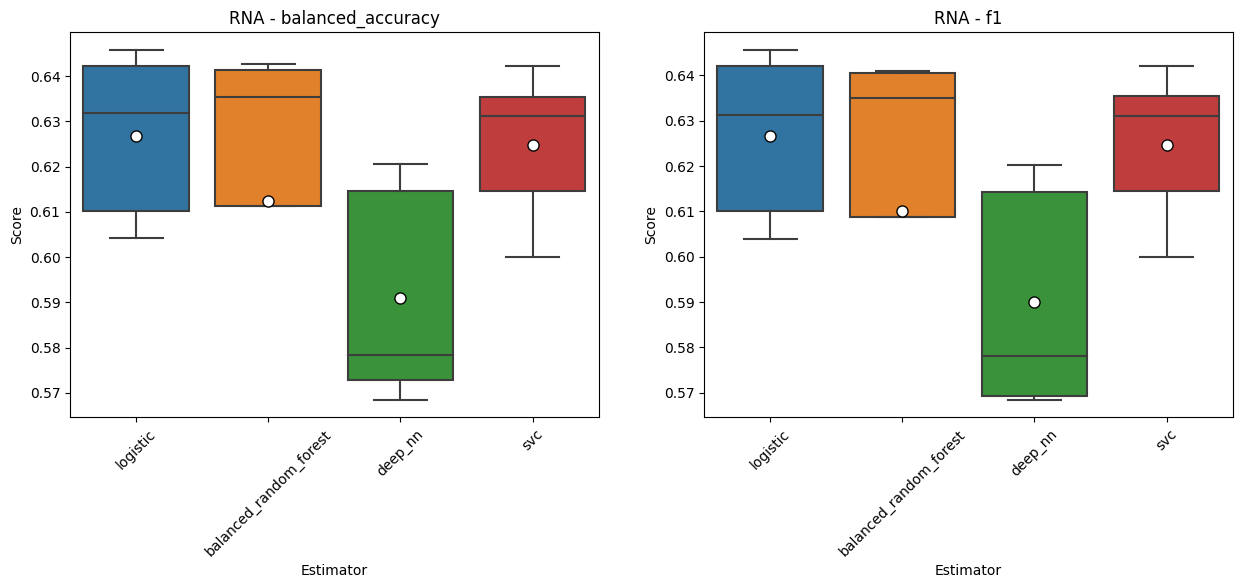

In [80]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

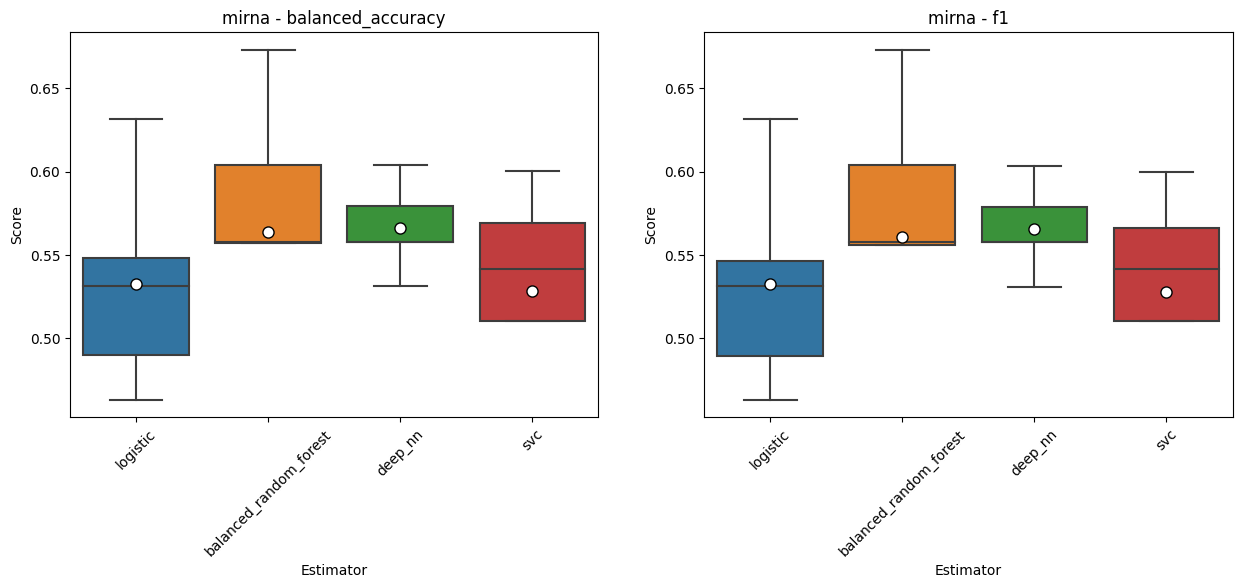

In [81]:
plot_box_scores(estimator_names, base_scores['mirna'], 'mirna', metrics=['balanced_accuracy', 'f1'])

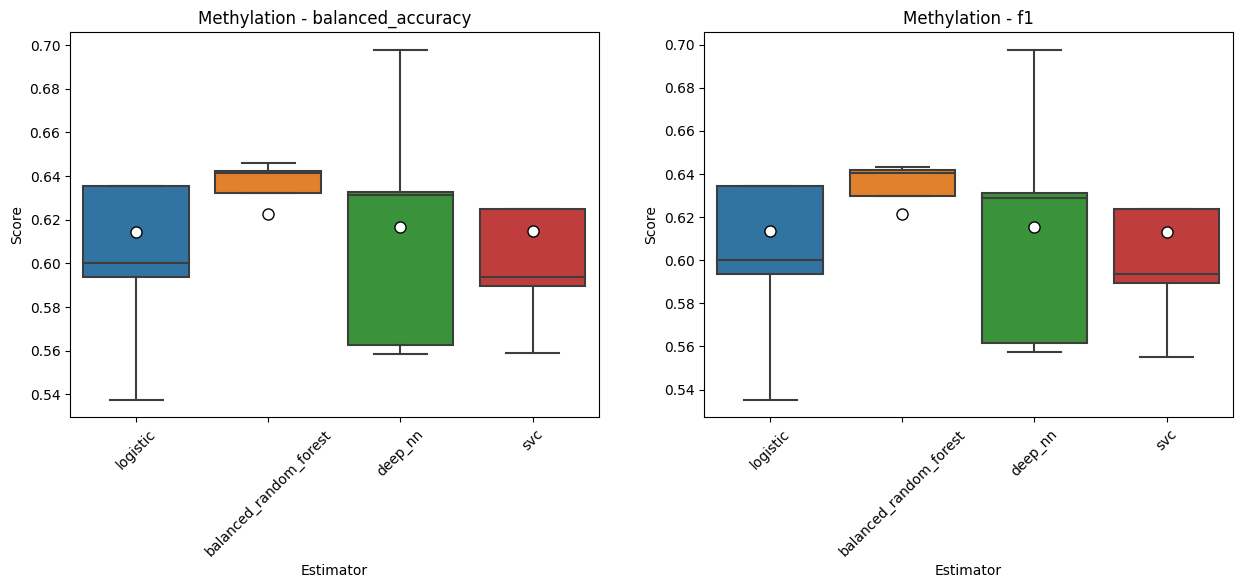

In [82]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

## Modality Ensemble

In [83]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method
        
    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])
        
        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)
        
        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking
        
        return model
    
    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)
        self.classes_ = self.model_.classes_
        self.coef_ = self.model_.final_estimator_.named_steps['final'].coef_
        
        return self
    
    def predict(self, X):
        return self.model_.predict(X)
    
    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [84]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [85]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (low)': make_scorer(recall_multiclass, label=1), 'recall (high)': make_scorer(recall_multiclass, label=0)})
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.w

            accuracy balanced_accuracy               f1     recall (low)  \
rna  0.623 +/- 0.036   0.622 +/- 0.036  0.622 +/- 0.036  0.581 +/- 0.034   

       recall (high)  
rna  0.663 +/- 0.051  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

              accuracy balanced_accuracy               f1     recall (low)  \
mirna  0.564 +/- 0.021   0.564 +/- 0.021  0.564 +/- 0.021  0.556 +/- 0.044   

         recall (high)  
mirna  0.571 +/- 0.030  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

                    accuracy balanced_accuracy               f1  \
methylation  0.631 +/- 0.025   0.631 +/- 0.025  0.629 +/- 0.023   

                recall (low)    recall (high)  
methylation  0.561 +/- 0.027  0.702 +/- 0.062  


In [86]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (low),recall (high)
rna,0.623 +/- 0.036,0.622 +/- 0.036,0.622 +/- 0.036,0.581 +/- 0.034,0.663 +/- 0.051
mirna,0.564 +/- 0.021,0.564 +/- 0.021,0.564 +/- 0.021,0.556 +/- 0.044,0.571 +/- 0.030
methylation,0.631 +/- 0.025,0.631 +/- 0.025,0.629 +/- 0.023,0.561 +/- 0.027,0.702 +/- 0.062


In [87]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = base_scores
all_scores['rna'].append(scores['rna'])
all_scores['mirna'].append(scores['mirna'])
all_scores['methylation'].append(scores['methylation'])

In [88]:
all_metrics = {}

# Joining metrics together for visualization
for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [89]:
# Balanced random forest and standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['mirna'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (low),recall (high)
logistic,0.627 +/- 0.017,0.627 +/- 0.017,0.627 +/- 0.017,0.611 +/- 0.033,0.643 +/- 0.016
balanced_random_forest,0.612 +/- 0.042,0.612 +/- 0.042,0.610 +/- 0.044,0.557 +/- 0.081,0.668 +/- 0.039
deep_nn,0.591 +/- 0.022,0.591 +/- 0.022,0.590 +/- 0.023,0.615 +/- 0.040,0.567 +/- 0.062
svc,0.625 +/- 0.015,0.625 +/- 0.015,0.625 +/- 0.015,0.615 +/- 0.018,0.634 +/- 0.026
rna,0.623 +/- 0.036,0.622 +/- 0.036,0.622 +/- 0.036,0.581 +/- 0.034,0.663 +/- 0.051


,accuracy,balanced_accuracy,f1,recall (low),recall (high)
logistic,0.533 +/- 0.058,0.533 +/- 0.058,0.532 +/- 0.058,0.519 +/- 0.052,0.547 +/- 0.071
balanced_random_forest,0.564 +/- 0.081,0.564 +/- 0.080,0.561 +/- 0.085,0.531 +/- 0.149,0.597 +/- 0.031
deep_nn,0.566 +/- 0.024,0.566 +/- 0.024,0.566 +/- 0.024,0.548 +/- 0.024,0.584 +/- 0.034
svc,0.528 +/- 0.061,0.529 +/- 0.061,0.528 +/- 0.061,0.514 +/- 0.055,0.543 +/- 0.079
mirna,0.564 +/- 0.021,0.564 +/- 0.021,0.564 +/- 0.021,0.556 +/- 0.044,0.571 +/- 0.030


,accuracy,balanced_accuracy,f1,recall (low),recall (high)
logistic,0.614 +/- 0.055,0.615 +/- 0.056,0.613 +/- 0.055,0.577 +/- 0.051,0.652 +/- 0.077
balanced_random_forest,0.623 +/- 0.036,0.623 +/- 0.036,0.621 +/- 0.035,0.569 +/- 0.033,0.677 +/- 0.052
deep_nn,0.616 +/- 0.052,0.616 +/- 0.052,0.615 +/- 0.052,0.586 +/- 0.051,0.647 +/- 0.079
svc,0.614 +/- 0.050,0.615 +/- 0.050,0.613 +/- 0.050,0.573 +/- 0.051,0.656 +/- 0.076
methylation,0.631 +/- 0.025,0.631 +/- 0.025,0.629 +/- 0.023,0.561 +/- 0.027,0.702 +/- 0.062


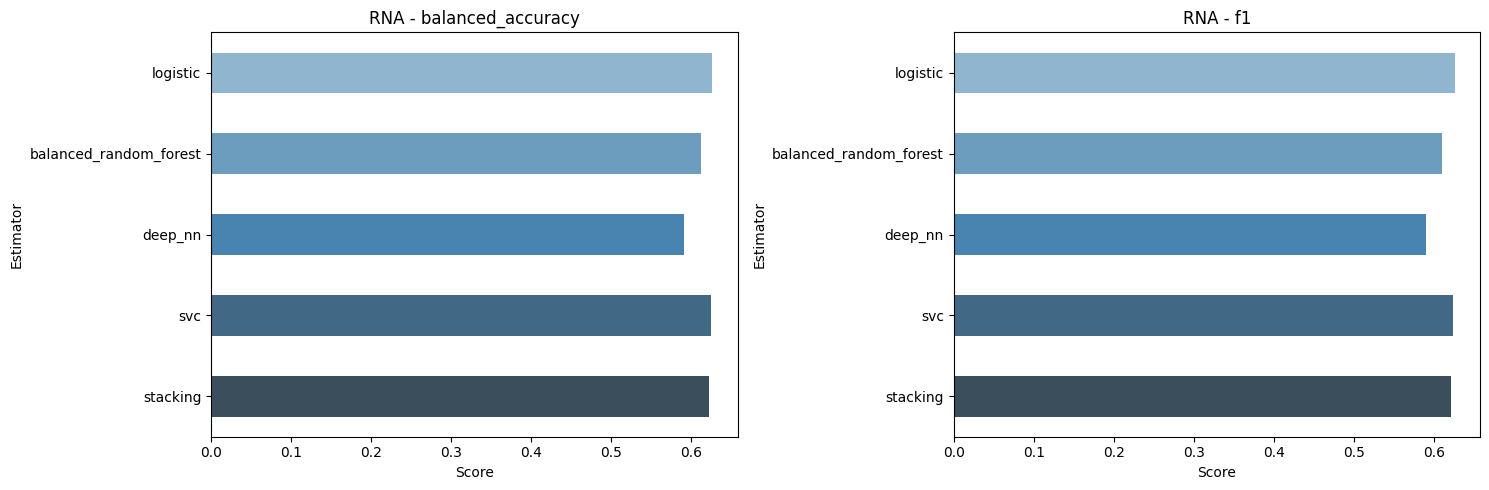

In [90]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

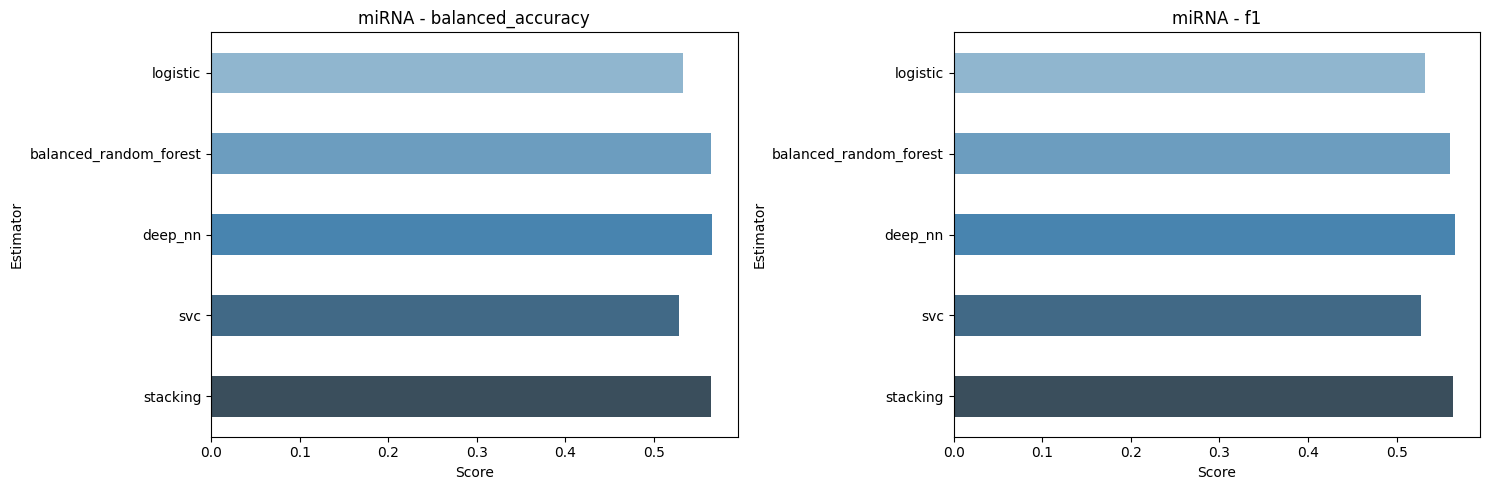

In [91]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

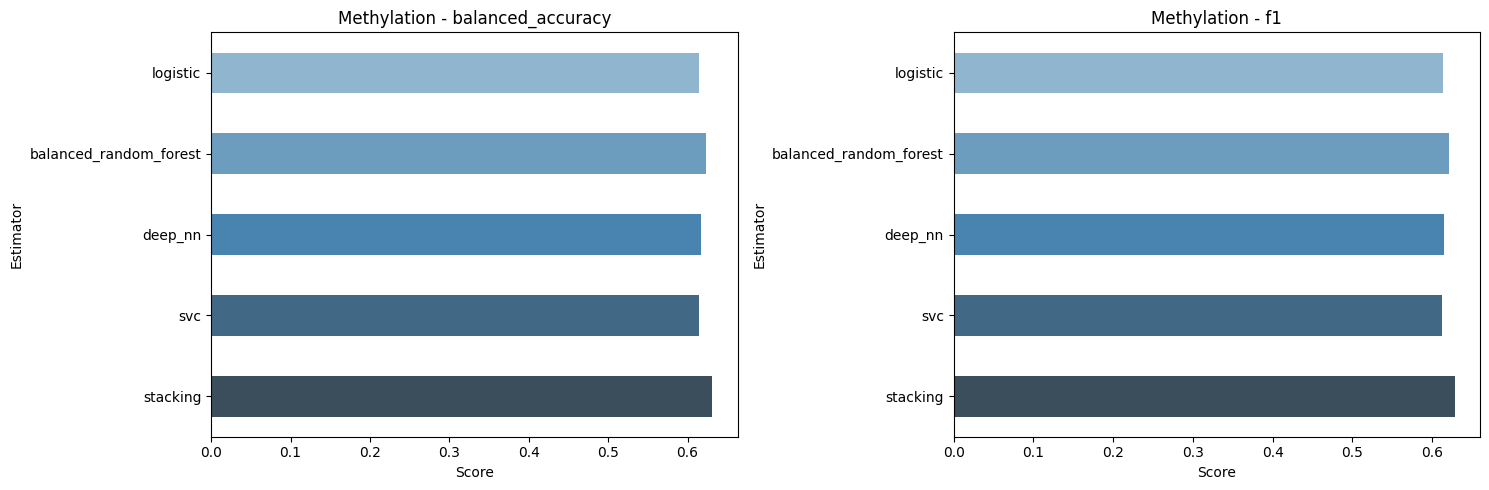

In [92]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

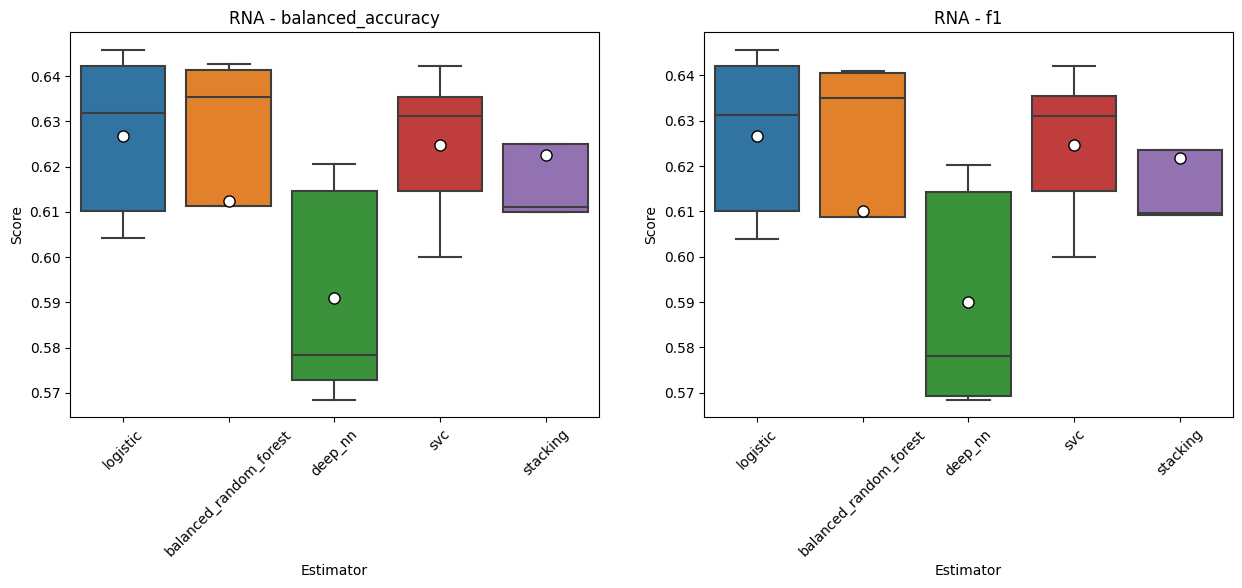

In [93]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

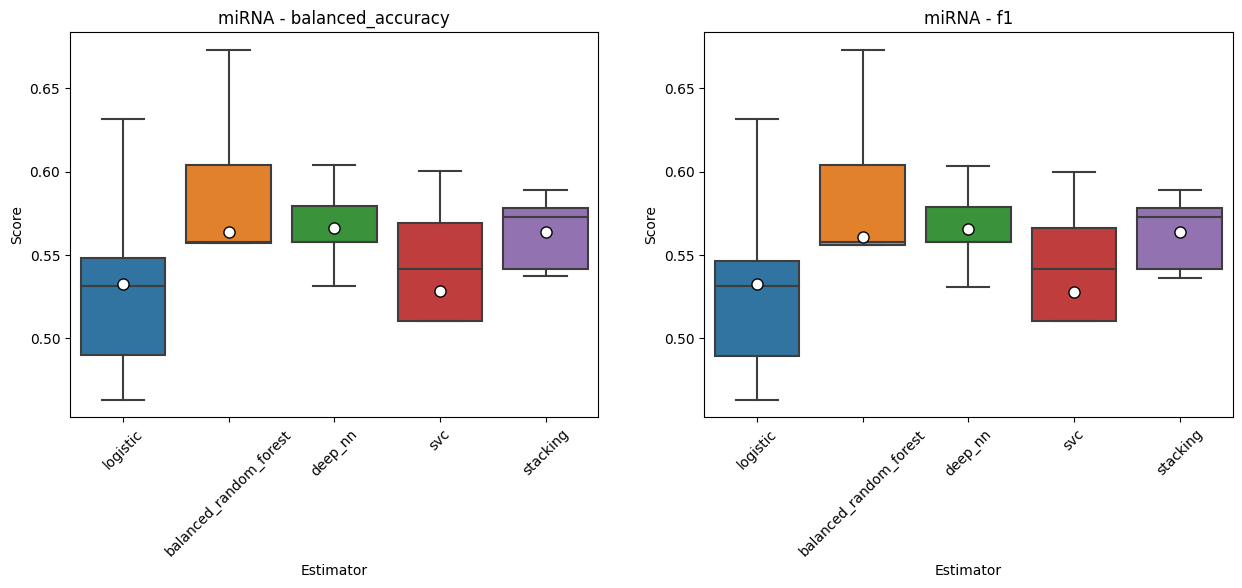

In [94]:
plot_box_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

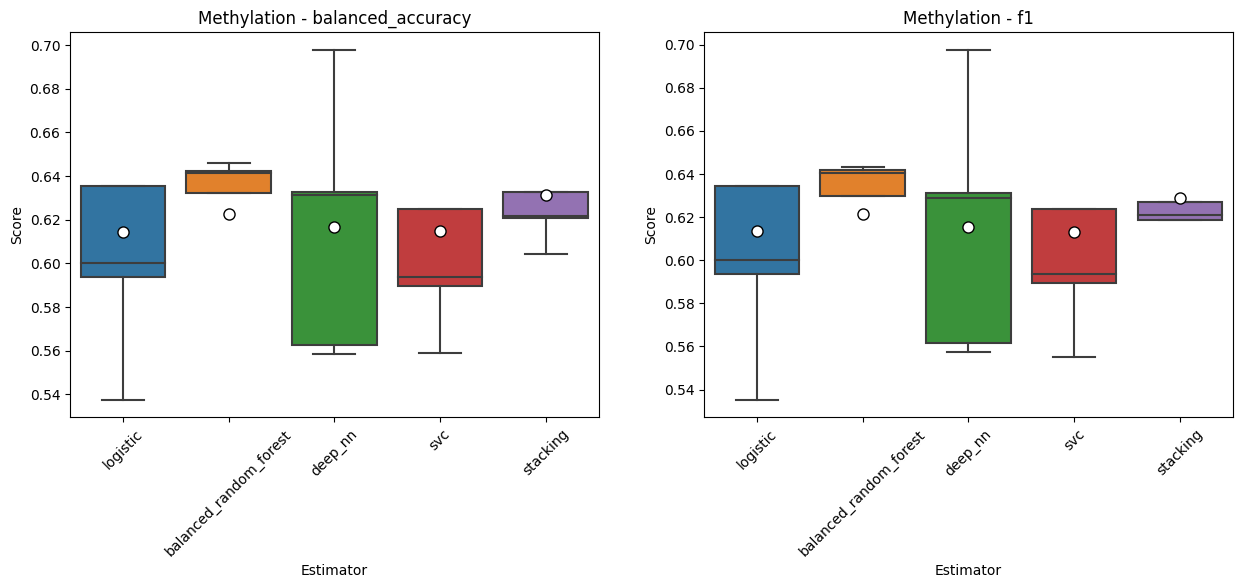

In [95]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

In [96]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1, method='predict_proba')

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.w

In [97]:
# Making dataframe of predicted class out of probabilities
preds_class_df = pd.DataFrame({
    'rna': preds['rna'].argmax(axis=1),
    'cnv': preds['mirna'].argmax(axis=1),
    'methylation': preds['methylation'].argmax(axis=1)
})

# Making dataframe of predicted probabilities
preds_proba_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna_low', 'rna_high']), pd.DataFrame(preds['mirna'], columns=['mirna_low', 'mirna_high']), pd.DataFrame(preds['methylation'], columns=['meth_low', 'meth_high'])], axis=1)

In [98]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score

def calculate_voting_scores(preds_class_df, y, name):
    # Find the majority class for each sample
    majority_class = preds_class_df.mode(axis=1)[0]

    # Calculate the scores
    accuracy = accuracy_score(y, majority_class)
    balanced_accuracy = balanced_accuracy_score(y, majority_class)
    f1 = f1_score(y, majority_class, average='weighted')
    recall = recall_score(y, majority_class, average=None)

    # Create a DataFrame with the scores
    scores_df = pd.DataFrame({
        'accuracy': [accuracy],
        'balanced_accuracy': [balanced_accuracy],
        'f1': [f1],
        'recall (low)': [recall[1]],
        'recall (high)': [recall[0]],
    })

    return scores_df.rename(index={0: name})

In [99]:
preds_class_df

,rna,cnv,methylation
0,0,0,0
1,1,1,1
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
472,0,1,0
473,0,0,0
474,0,0,1
475,1,1,0


In [100]:
rna_mirna_meth = calculate_voting_scores(preds_class_df, y, 'rna_mirna_meth')
mirna_meth = calculate_voting_scores(preds_class_df[['cnv', 'methylation']], y, 'mirna_meth')
rna_meth = calculate_voting_scores(preds_class_df[['rna', 'methylation']], y, 'rna_meth')
rna_mirna = calculate_voting_scores(preds_class_df[['rna', 'cnv']], y, 'rna_mirna')

In [101]:
# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, rna_mirna_meth, mirna_meth, rna_meth, rna_mirna])
integration_voting_metrics

,accuracy,balanced_accuracy,f1,recall (low),recall (high)
rna,0.623 +/- 0.036,0.622 +/- 0.036,0.622 +/- 0.036,0.581 +/- 0.034,0.663 +/- 0.051
mirna,0.564 +/- 0.021,0.564 +/- 0.021,0.564 +/- 0.021,0.556 +/- 0.044,0.571 +/- 0.030
methylation,0.631 +/- 0.025,0.631 +/- 0.025,0.629 +/- 0.023,0.561 +/- 0.027,0.702 +/- 0.062
rna_mirna_meth,0.631027,0.631157,0.629611,0.569038,0.693277
mirna_meth,0.599581,0.600023,0.580989,0.389121,0.810924
rna_meth,0.624738,0.625145,0.610081,0.430962,0.819328
rna_mirna,0.580713,0.581159,0.560837,0.368201,0.794118


### Stacking

In [102]:
rna_mirna_meth_scores, rna_mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df, y, name='rna + mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'),'recall (low)': make_scorer(recall_multiclass, label=1), 'recall (high)': make_scorer(recall_multiclass, label=0)})
mirna_meth_scores, mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['mirna_low', 'mirna_high', 'meth_low', 'meth_high']], y, name='mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (low)': make_scorer(recall_multiclass, label=1), 'recall (high)': make_scorer(recall_multiclass, label=0)})
rna_meth_scores, rna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_low', 'rna_high', 'meth_low', 'meth_high']], y, name='rna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (low)': make_scorer(recall_multiclass, label=1), 'recall (high)': make_scorer(recall_multiclass, label=0)})
rna_mirna_scores, rna_mirna_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_low', 'rna_high', 'mirna_low', 'mirna_high']], y, name='rna + mirna', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (low)': make_scorer(recall_multiclass, label=1), 'recall (high)': make_scorer(recall_multiclass, label=0)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [103]:
integration_stacking_metrics = pd.concat([modality_metrics, rna_mirna_meth_df, mirna_meth_df, rna_meth_df, rna_mirna_df])

In [104]:
integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (low),recall (high)
rna,0.623 +/- 0.036,0.622 +/- 0.036,0.622 +/- 0.036,0.581 +/- 0.034,0.663 +/- 0.051
mirna,0.564 +/- 0.021,0.564 +/- 0.021,0.564 +/- 0.021,0.556 +/- 0.044,0.571 +/- 0.030
methylation,0.631 +/- 0.025,0.631 +/- 0.025,0.629 +/- 0.023,0.561 +/- 0.027,0.702 +/- 0.062
rna + mirna + methylation,0.610 +/- 0.034,0.610 +/- 0.034,0.609 +/- 0.034,0.590 +/- 0.053,0.631 +/- 0.072
mirna + methylation,0.627 +/- 0.027,0.627 +/- 0.028,0.625 +/- 0.027,0.573 +/- 0.027,0.681 +/- 0.070
rna + methylation,0.614 +/- 0.034,0.615 +/- 0.034,0.613 +/- 0.035,0.594 +/- 0.063,0.635 +/- 0.072
rna + mirna,0.610 +/- 0.026,0.610 +/- 0.026,0.609 +/- 0.026,0.577 +/- 0.026,0.643 +/- 0.038


In [106]:
names = ['rna', 'mirna', 'methylation', 'rna + mirna + meth', 'mirna + meth', 'rna + meth', 'rna + mirna']
integration = []
integration.append(scores['rna'])
integration.append(scores['mirna'])
integration.append(scores['methylation'])
integration.append(rna_mirna_meth_scores)
integration.append(mirna_meth_scores)
integration.append(rna_meth_scores)
integration.append(rna_mirna_scores)

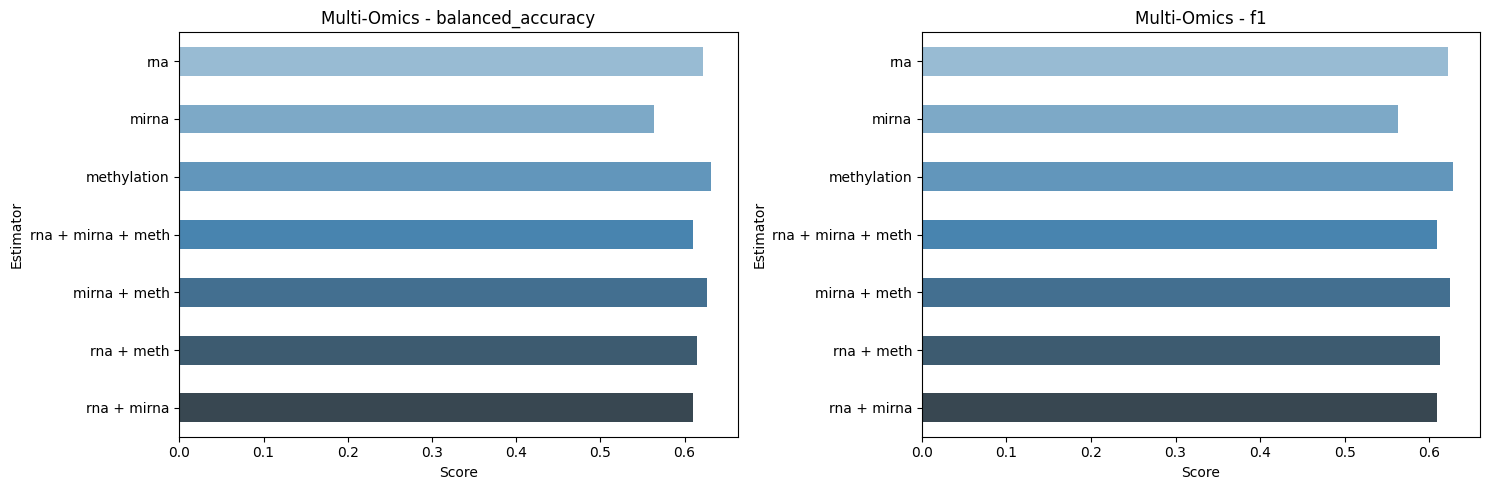

In [107]:
plot_bar_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

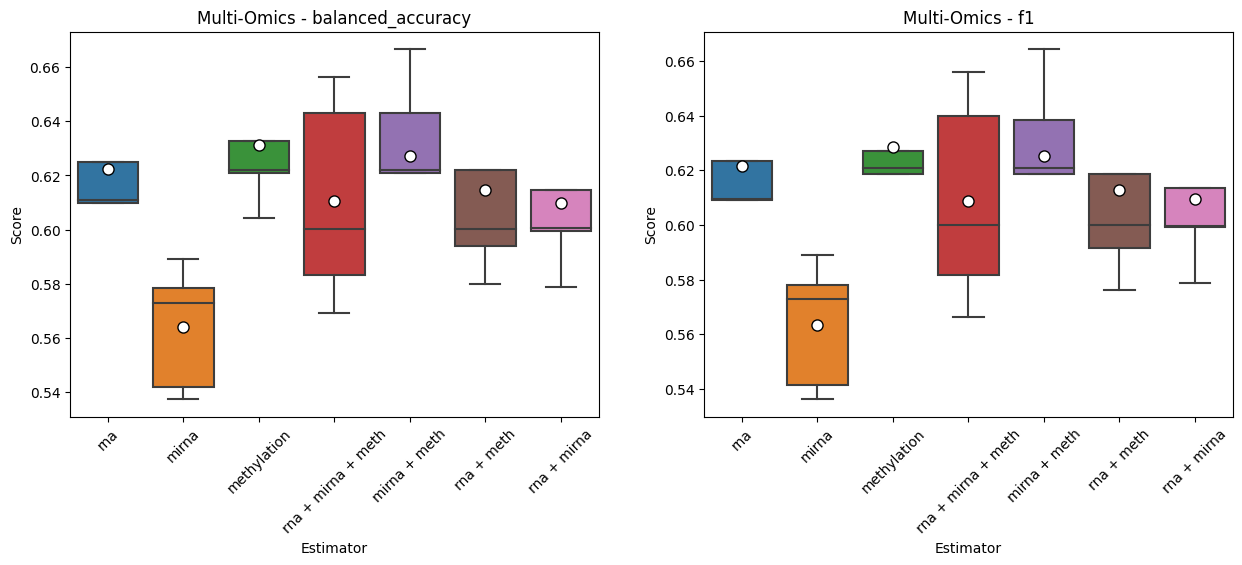

In [108]:
plot_box_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

# Subtyping

## Preprocessing

### Removing low-variance + null features

In [112]:
subtypes = pd.read_csv(labels, index_col=0)

In [113]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality], 0.05)
    print(modality, new_data[modality].shape)

rna (477, 19055)
mirna (477, 520)
methylation (477, 1088)


In [114]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in data:
    X[modality] = pd.DataFrame(data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (477, 20118)
mirna (477, 791)
methylation (477, 18137)


In [116]:
subtypes['histological_type'].value_counts()

astrocytoma          179
oligodendroglioma    174
oligoastrocytoma     124
Name: histological_type, dtype: int64

In [117]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['histological_type'])
enc.inverse_transform([0, 1, 2])

array(['astrocytoma', 'oligoastrocytoma', 'oligodendroglioma'],
      dtype=object)

## Base Learners

In [118]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

In [119]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (astro)': make_scorer(recall_multiclass, label=0), 'recall (oligoastro)': make_scorer(recall_multiclass, label=1), 'recall (oligodendro)': make_scorer(recall_multiclass, label=2)})

 25%|██▌       | 1/4 [00:58<02:56, 58.67s/it]

logistic                  accuracy balanced_accuracy               f1   recall (astro)  \
logistic  0.587 +/- 0.013   0.549 +/- 0.011  0.568 +/- 0.011  0.749 +/- 0.091   

         recall (oligoastro) recall (oligodendro)  
logistic     0.209 +/- 0.045      0.690 +/- 0.075  


 50%|█████     | 2/4 [01:33<01:29, 44.81s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.572 +/- 0.017   0.534 +/- 0.022  0.553 +/- 0.026   

                         recall (astro) recall (oligoastro)  \
balanced_random_forest  0.738 +/- 0.081     0.193 +/- 0.068   

                       recall (oligodendro)  
balanced_random_forest      0.673 +/- 0.085  


 75%|███████▌  | 3/4 [02:18<00:44, 44.97s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (astro)  \
deep_nn  0.572 +/- 0.037   0.540 +/- 0.037  0.557 +/- 0.033  0.733 +/- 0.120   

        recall (oligoastro) recall (oligodendro)  
deep_nn     0.250 +/- 0.055      0.638 +/- 0.097  


100%|██████████| 4/4 [02:41<00:00, 40.31s/it]


svc             accuracy balanced_accuracy               f1   recall (astro)  \
svc  0.572 +/- 0.019   0.538 +/- 0.019  0.558 +/- 0.016  0.732 +/- 0.057   

    recall (oligoastro) recall (oligodendro)  
svc     0.226 +/- 0.033      0.655 +/- 0.058  


 25%|██▌       | 1/4 [00:02<00:08,  2.78s/it]

logistic                  accuracy balanced_accuracy               f1   recall (astro)  \
logistic  0.555 +/- 0.061   0.534 +/- 0.062  0.553 +/- 0.059  0.620 +/- 0.066   

         recall (oligoastro) recall (oligodendro)  
logistic     0.338 +/- 0.085      0.643 +/- 0.117  


 50%|█████     | 2/4 [00:06<00:06,  3.29s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.570 +/- 0.033   0.530 +/- 0.034  0.547 +/- 0.035   

                         recall (astro) recall (oligoastro)  \
balanced_random_forest  0.760 +/- 0.048     0.169 +/- 0.059   

                       recall (oligodendro)  
balanced_random_forest      0.661 +/- 0.093  


 75%|███████▌  | 3/4 [00:11<00:04,  4.04s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (astro)  \
deep_nn  0.553 +/- 0.066   0.520 +/- 0.067  0.537 +/- 0.069  0.676 +/- 0.086   

        recall (oligoastro) recall (oligodendro)  
deep_nn     0.217 +/- 0.089      0.667 +/- 0.084  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

svc             accuracy balanced_accuracy               f1   recall (astro)  \
svc  0.532 +/- 0.060   0.508 +/- 0.060  0.529 +/- 0.059  0.637 +/- 0.114   

    recall (oligoastro) recall (oligodendro)  
svc     0.290 +/- 0.068      0.597 +/- 0.095  


 25%|██▌       | 1/4 [00:27<01:23, 27.94s/it]

logistic                  accuracy balanced_accuracy               f1   recall (astro)  \
logistic  0.600 +/- 0.046   0.550 +/- 0.047  0.556 +/- 0.043  0.805 +/- 0.057   

         recall (oligoastro) recall (oligodendro)  
logistic     0.104 +/- 0.040      0.741 +/- 0.087  


 50%|█████     | 2/4 [00:49<00:48, 24.43s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.581 +/- 0.070   0.542 +/- 0.071  0.560 +/- 0.070   

                         recall (astro) recall (oligoastro)  \
balanced_random_forest  0.755 +/- 0.076     0.192 +/- 0.102   

                       recall (oligodendro)  
balanced_random_forest      0.678 +/- 0.110  


 75%|███████▌  | 3/4 [01:31<00:32, 32.35s/it]

deep_nn                 accuracy balanced_accuracy               f1   recall (astro)  \
deep_nn  0.555 +/- 0.050   0.515 +/- 0.046  0.529 +/- 0.044  0.669 +/- 0.126   

        recall (oligoastro) recall (oligodendro)  
deep_nn     0.146 +/- 0.058      0.730 +/- 0.100  


100%|██████████| 4/4 [01:47<00:00, 26.89s/it]

svc             accuracy balanced_accuracy               f1   recall (astro)  \
svc  0.591 +/- 0.049   0.548 +/- 0.049  0.560 +/- 0.048  0.777 +/- 0.067   

    recall (oligoastro) recall (oligodendro)  
svc     0.153 +/- 0.058      0.713 +/- 0.102  


In [120]:
display(base_metrics_df['rna']), display(base_metrics_df['mirna']), display(base_metrics_df['methylation'])

,accuracy,balanced_accuracy,f1,recall (astro),recall (oligoastro),recall (oligodendro)
logistic,0.587 +/- 0.013,0.549 +/- 0.011,0.568 +/- 0.011,0.749 +/- 0.091,0.209 +/- 0.045,0.690 +/- 0.075
balanced_random_forest,0.572 +/- 0.017,0.534 +/- 0.022,0.553 +/- 0.026,0.738 +/- 0.081,0.193 +/- 0.068,0.673 +/- 0.085
deep_nn,0.572 +/- 0.037,0.540 +/- 0.037,0.557 +/- 0.033,0.733 +/- 0.120,0.250 +/- 0.055,0.638 +/- 0.097
svc,0.572 +/- 0.019,0.538 +/- 0.019,0.558 +/- 0.016,0.732 +/- 0.057,0.226 +/- 0.033,0.655 +/- 0.058


,accuracy,balanced_accuracy,f1,recall (astro),recall (oligoastro),recall (oligodendro)
logistic,0.555 +/- 0.061,0.534 +/- 0.062,0.553 +/- 0.059,0.620 +/- 0.066,0.338 +/- 0.085,0.643 +/- 0.117
balanced_random_forest,0.570 +/- 0.033,0.530 +/- 0.034,0.547 +/- 0.035,0.760 +/- 0.048,0.169 +/- 0.059,0.661 +/- 0.093
deep_nn,0.553 +/- 0.066,0.520 +/- 0.067,0.537 +/- 0.069,0.676 +/- 0.086,0.217 +/- 0.089,0.667 +/- 0.084
svc,0.532 +/- 0.060,0.508 +/- 0.060,0.529 +/- 0.059,0.637 +/- 0.114,0.290 +/- 0.068,0.597 +/- 0.095


,accuracy,balanced_accuracy,f1,recall (astro),recall (oligoastro),recall (oligodendro)
logistic,0.600 +/- 0.046,0.550 +/- 0.047,0.556 +/- 0.043,0.805 +/- 0.057,0.104 +/- 0.040,0.741 +/- 0.087
balanced_random_forest,0.581 +/- 0.070,0.542 +/- 0.071,0.560 +/- 0.070,0.755 +/- 0.076,0.192 +/- 0.102,0.678 +/- 0.110
deep_nn,0.555 +/- 0.050,0.515 +/- 0.046,0.529 +/- 0.044,0.669 +/- 0.126,0.146 +/- 0.058,0.730 +/- 0.100
svc,0.591 +/- 0.049,0.548 +/- 0.049,0.560 +/- 0.048,0.777 +/- 0.067,0.153 +/- 0.058,0.713 +/- 0.102


(None, None, None)

In [121]:
estimator_names = [estimator[0] for estimator in estimators]

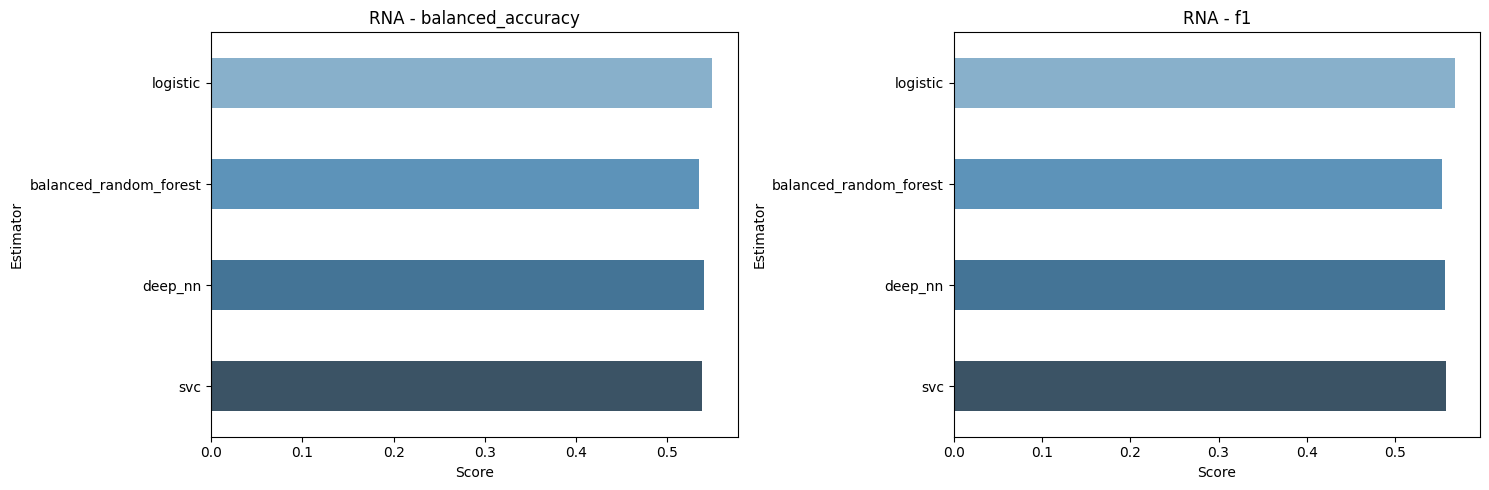

In [122]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

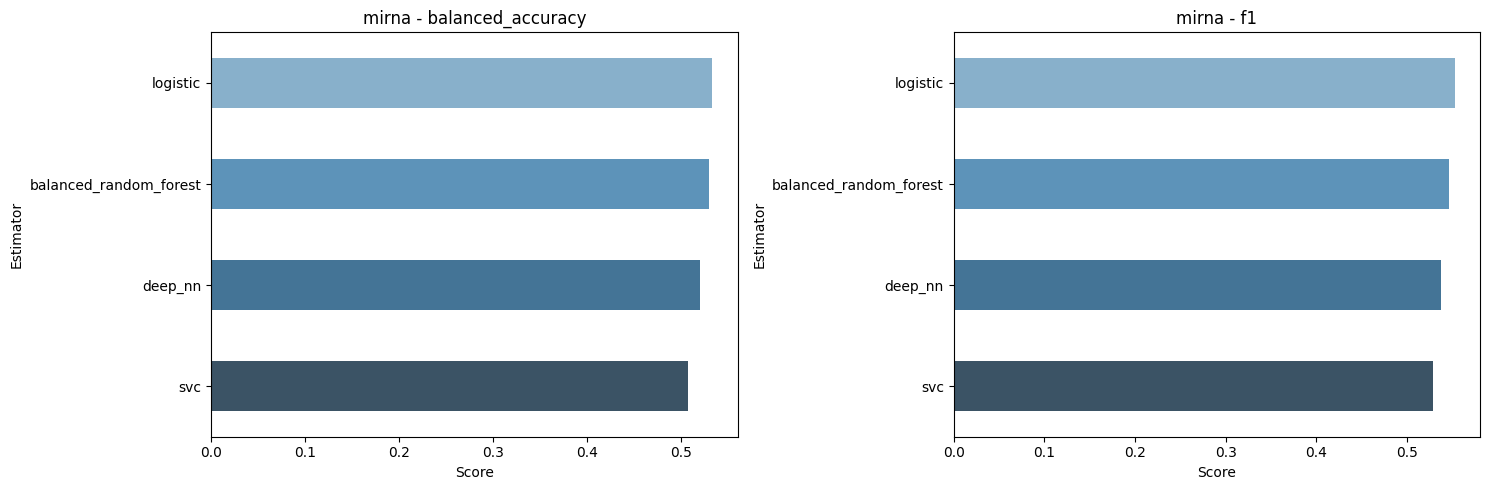

In [123]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'mirna', metrics=['balanced_accuracy', 'f1'])

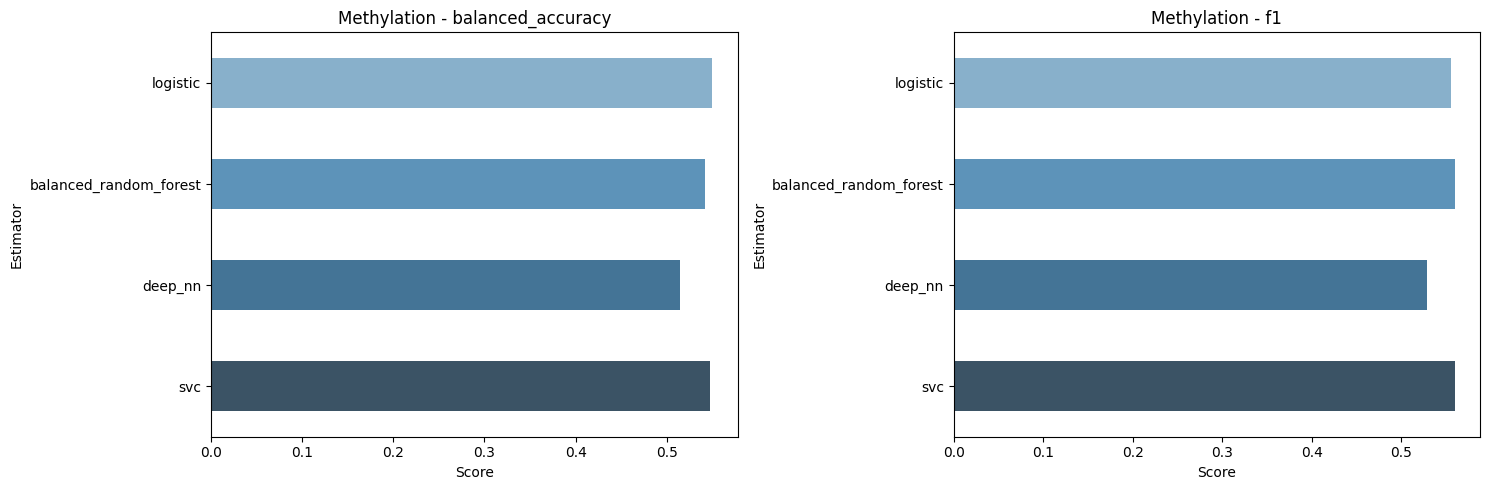

In [124]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

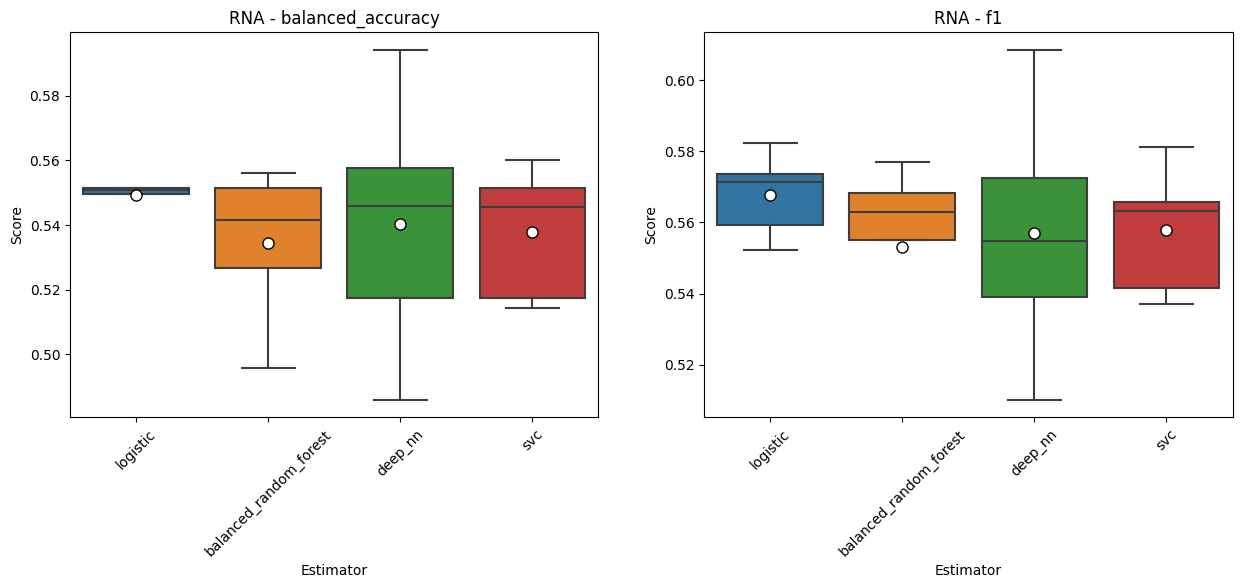

In [125]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

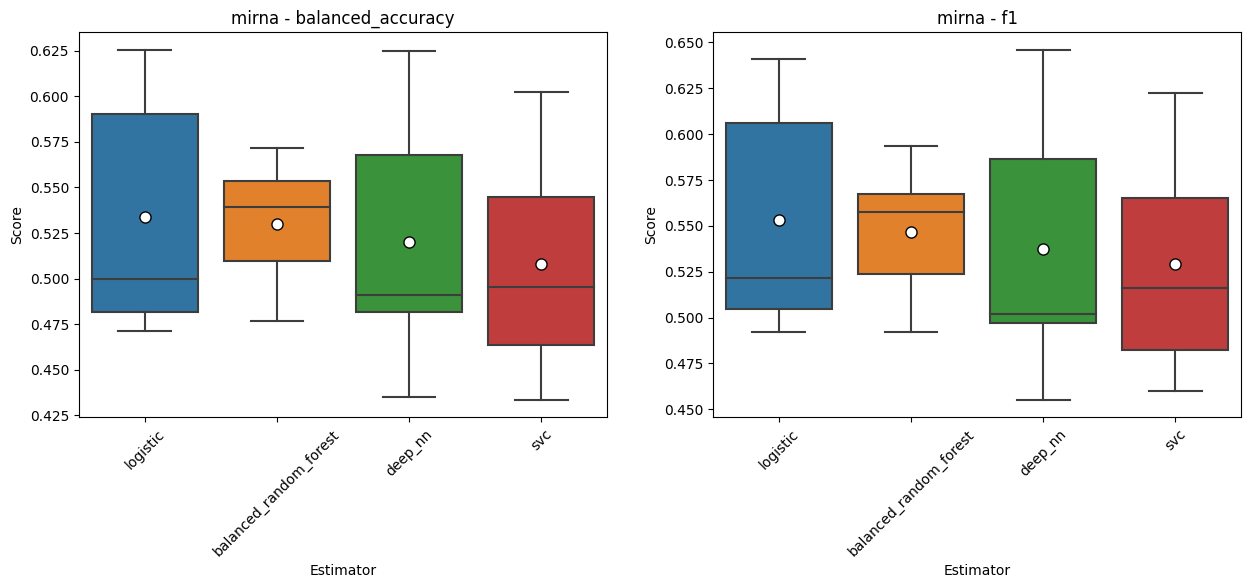

In [126]:
plot_box_scores(estimator_names, base_scores['mirna'], 'mirna', metrics=['balanced_accuracy', 'f1'])

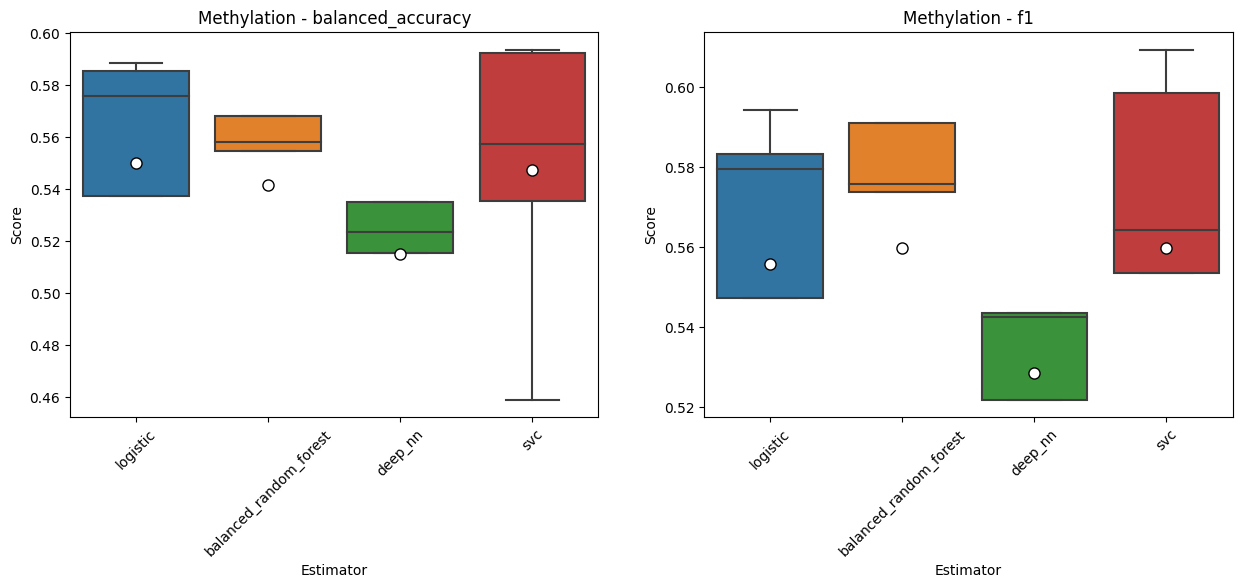

In [127]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

## Modality Ensemble

In [129]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [131]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (astro)': make_scorer(recall_multiclass, label=0), 'recall (oligoastro)': make_scorer(recall_multiclass, label=1), 'recall (oligodendro)': make_scorer(recall_multiclass, label=2)})
    modality_metrics = pd.concat([modality_metrics, df])
    print(df)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 33%|███▎      | 1/3 [07:43<15:26, 463.21s/it]

            accuracy balanced_accuracy               f1   recall (astro)  \
rna  0.593 +/- 0.039   0.542 +/- 0.040  0.540 +/- 0.042  0.822 +/- 0.059   

    recall (oligoastro) recall (oligodendro)  
rna     0.080 +/- 0.076      0.724 +/- 0.109  


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn

              accuracy balanced_accuracy               f1   recall (astro)  \
mirna  0.587 +/- 0.039   0.530 +/- 0.039  0.511 +/- 0.036  0.822 +/- 0.062   

      recall (oligoastro) recall (oligodendro)  
mirna     0.016 +/- 0.020      0.753 +/- 0.096  


100%|██████████| 3/3 [12:53<00:00, 257.89s/it]

                    accuracy balanced_accuracy               f1  \
methylation  0.618 +/- 0.036   0.560 +/- 0.037  0.543 +/- 0.037   

              recall (astro) recall (oligoastro) recall (oligodendro)  
methylation  0.866 +/- 0.053     0.032 +/- 0.047      0.782 +/- 0.091  


In [132]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (astro),recall (oligoastro),recall (oligodendro)
rna,0.593 +/- 0.039,0.542 +/- 0.040,0.540 +/- 0.042,0.822 +/- 0.059,0.080 +/- 0.076,0.724 +/- 0.109
mirna,0.587 +/- 0.039,0.530 +/- 0.039,0.511 +/- 0.036,0.822 +/- 0.062,0.016 +/- 0.020,0.753 +/- 0.096
methylation,0.618 +/- 0.036,0.560 +/- 0.037,0.543 +/- 0.037,0.866 +/- 0.053,0.032 +/- 0.047,0.782 +/- 0.091


In [133]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]

all_scores = base_scores
all_scores['rna'].append(scores['rna'])
all_scores['mirna'].append(scores['mirna'])
all_scores['methylation'].append(scores['methylation'])

In [134]:
all_metrics = {}

# Joining metrics together for visualization
for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [135]:
# Balanced random forest and standard scaler with deep neural network
display(all_metrics['rna'], all_metrics['mirna'], all_metrics['methylation'])

,accuracy,balanced_accuracy,f1,recall (astro),recall (oligoastro),recall (oligodendro)
logistic,0.587 +/- 0.013,0.549 +/- 0.011,0.568 +/- 0.011,0.749 +/- 0.091,0.209 +/- 0.045,0.690 +/- 0.075
balanced_random_forest,0.572 +/- 0.017,0.534 +/- 0.022,0.553 +/- 0.026,0.738 +/- 0.081,0.193 +/- 0.068,0.673 +/- 0.085
deep_nn,0.572 +/- 0.037,0.540 +/- 0.037,0.557 +/- 0.033,0.733 +/- 0.120,0.250 +/- 0.055,0.638 +/- 0.097
svc,0.572 +/- 0.019,0.538 +/- 0.019,0.558 +/- 0.016,0.732 +/- 0.057,0.226 +/- 0.033,0.655 +/- 0.058
rna,0.593 +/- 0.039,0.542 +/- 0.040,0.540 +/- 0.042,0.822 +/- 0.059,0.080 +/- 0.076,0.724 +/- 0.109


,accuracy,balanced_accuracy,f1,recall (astro),recall (oligoastro),recall (oligodendro)
logistic,0.555 +/- 0.061,0.534 +/- 0.062,0.553 +/- 0.059,0.620 +/- 0.066,0.338 +/- 0.085,0.643 +/- 0.117
balanced_random_forest,0.570 +/- 0.033,0.530 +/- 0.034,0.547 +/- 0.035,0.760 +/- 0.048,0.169 +/- 0.059,0.661 +/- 0.093
deep_nn,0.553 +/- 0.066,0.520 +/- 0.067,0.537 +/- 0.069,0.676 +/- 0.086,0.217 +/- 0.089,0.667 +/- 0.084
svc,0.532 +/- 0.060,0.508 +/- 0.060,0.529 +/- 0.059,0.637 +/- 0.114,0.290 +/- 0.068,0.597 +/- 0.095
mirna,0.587 +/- 0.039,0.530 +/- 0.039,0.511 +/- 0.036,0.822 +/- 0.062,0.016 +/- 0.020,0.753 +/- 0.096


,accuracy,balanced_accuracy,f1,recall (astro),recall (oligoastro),recall (oligodendro)
logistic,0.600 +/- 0.046,0.550 +/- 0.047,0.556 +/- 0.043,0.805 +/- 0.057,0.104 +/- 0.040,0.741 +/- 0.087
balanced_random_forest,0.581 +/- 0.070,0.542 +/- 0.071,0.560 +/- 0.070,0.755 +/- 0.076,0.192 +/- 0.102,0.678 +/- 0.110
deep_nn,0.555 +/- 0.050,0.515 +/- 0.046,0.529 +/- 0.044,0.669 +/- 0.126,0.146 +/- 0.058,0.730 +/- 0.100
svc,0.591 +/- 0.049,0.548 +/- 0.049,0.560 +/- 0.048,0.777 +/- 0.067,0.153 +/- 0.058,0.713 +/- 0.102
methylation,0.618 +/- 0.036,0.560 +/- 0.037,0.543 +/- 0.037,0.866 +/- 0.053,0.032 +/- 0.047,0.782 +/- 0.091


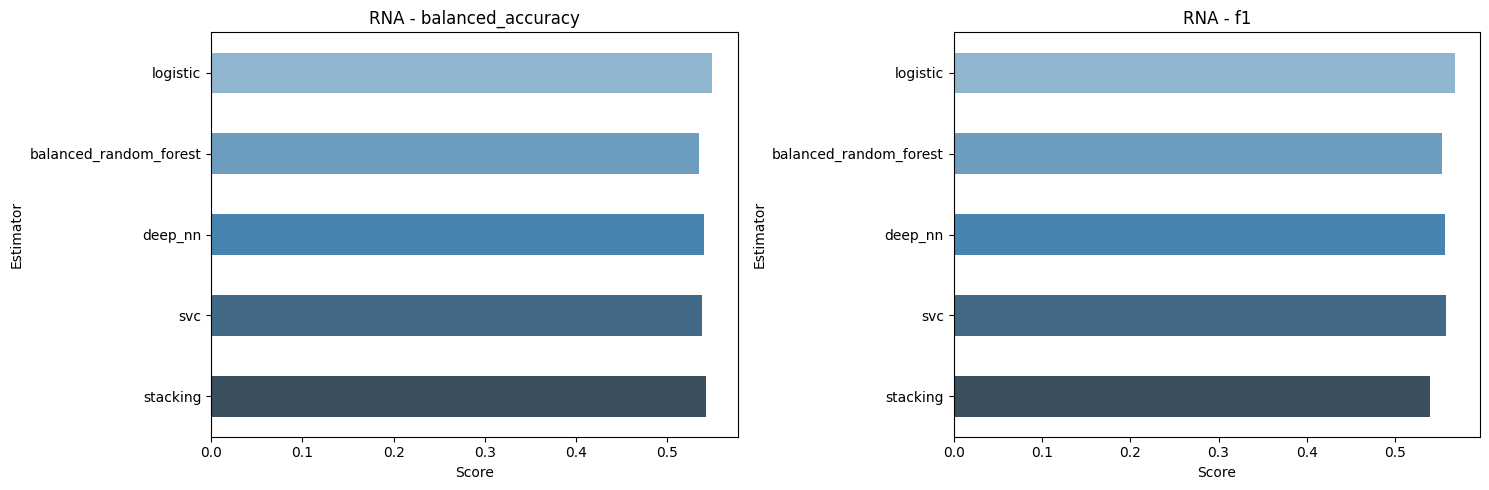

In [136]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

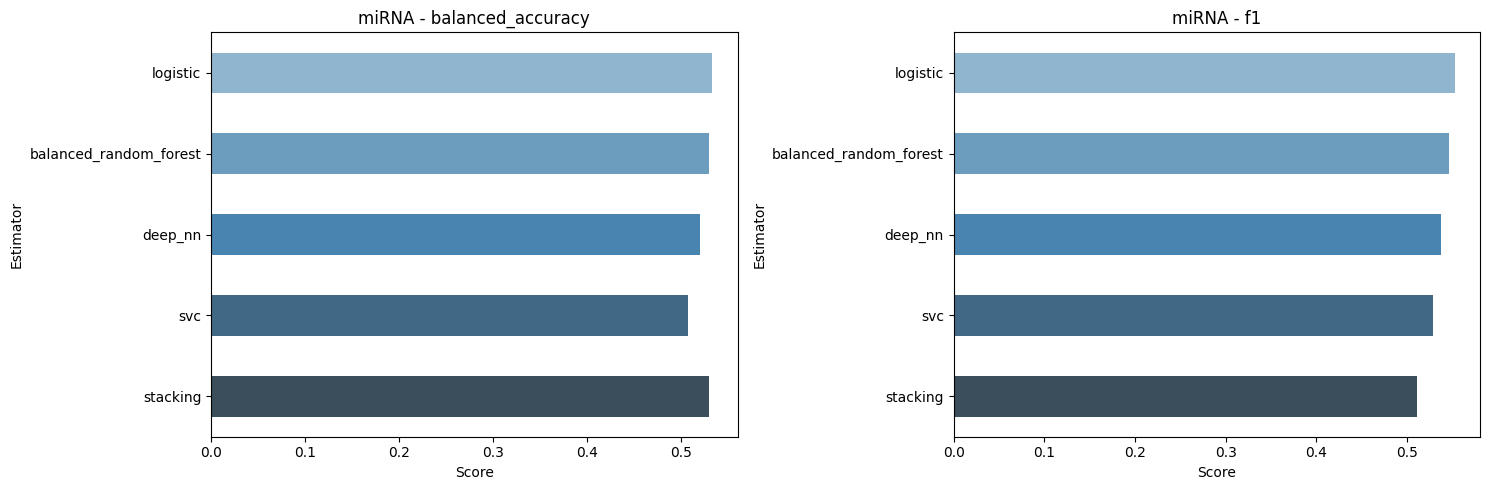

In [137]:
plot_bar_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

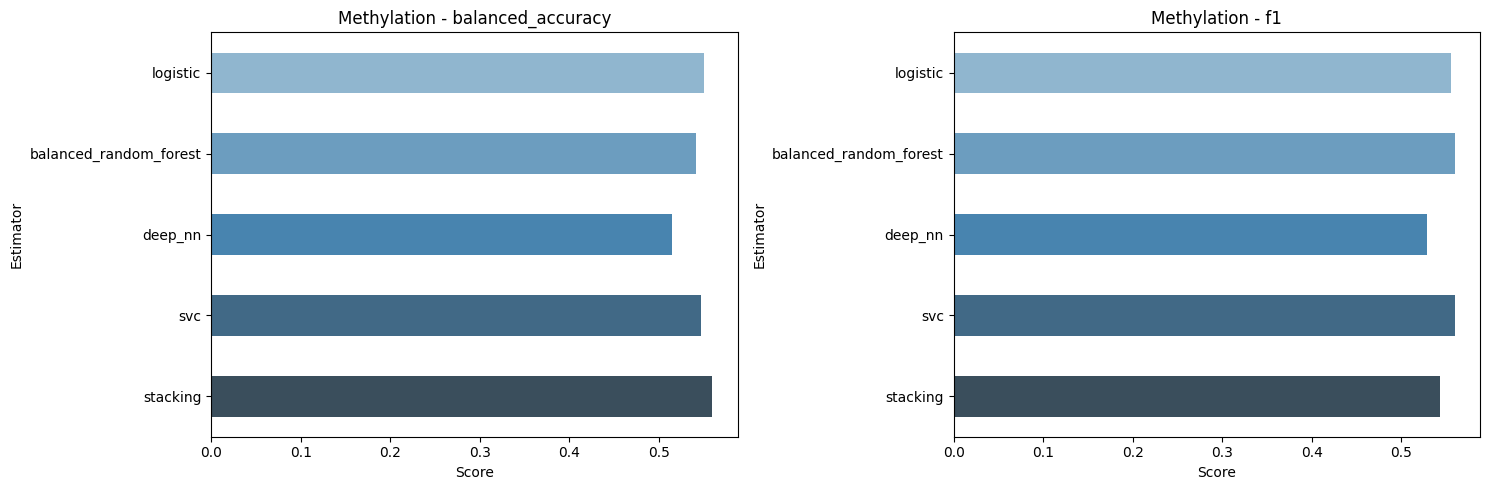

In [138]:
plot_bar_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

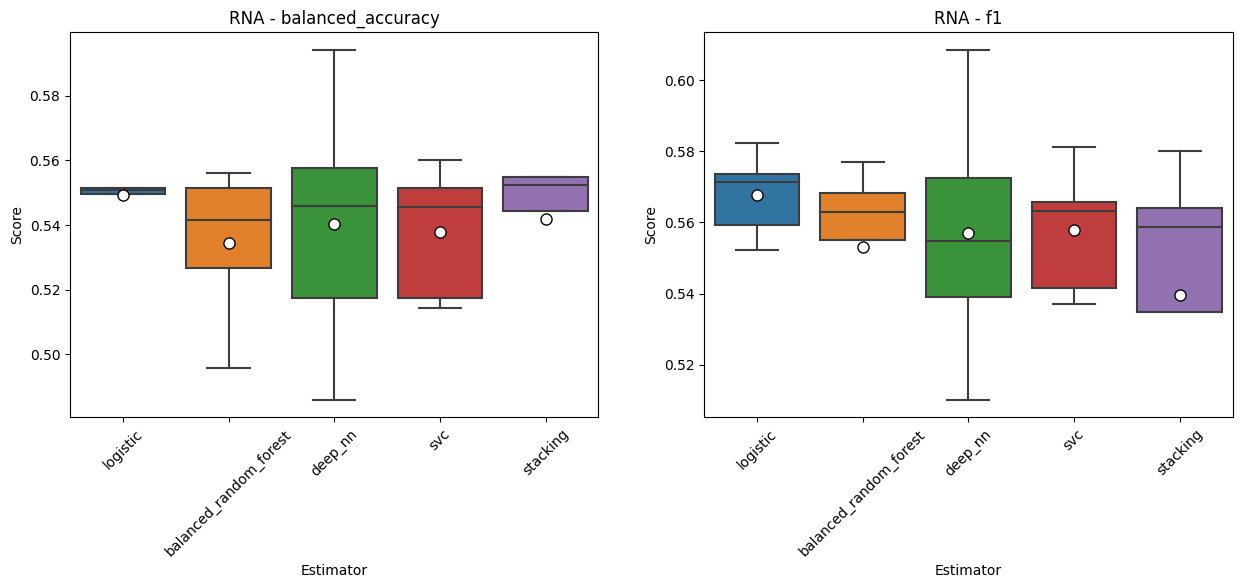

In [139]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

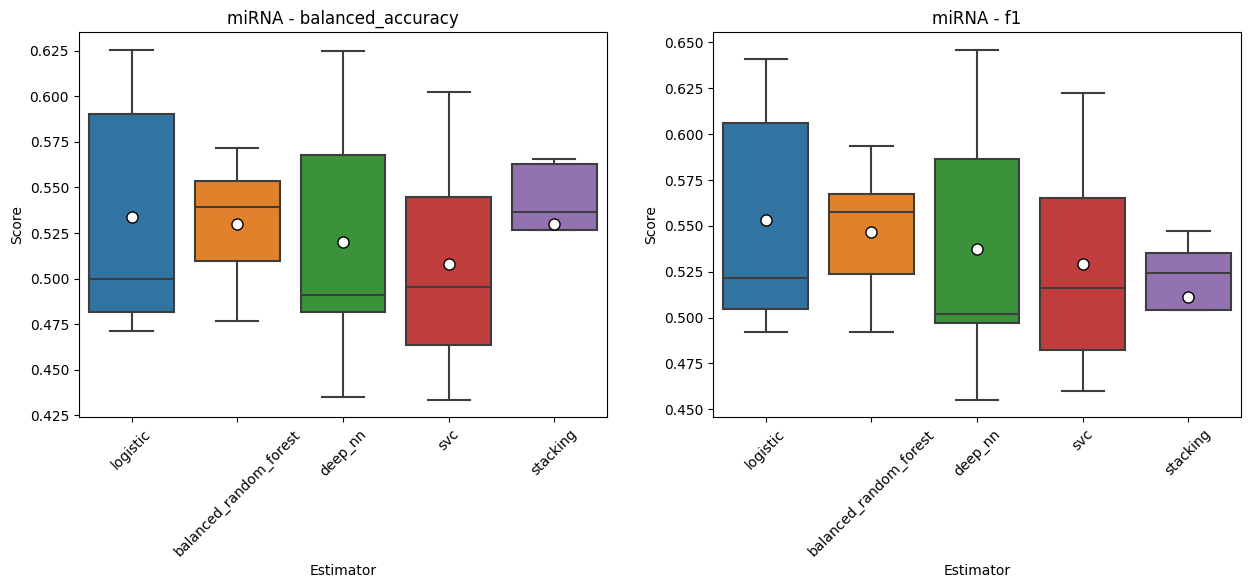

In [140]:
plot_box_scores(estimator_names, base_scores['mirna'], 'miRNA', metrics=['balanced_accuracy', 'f1'])

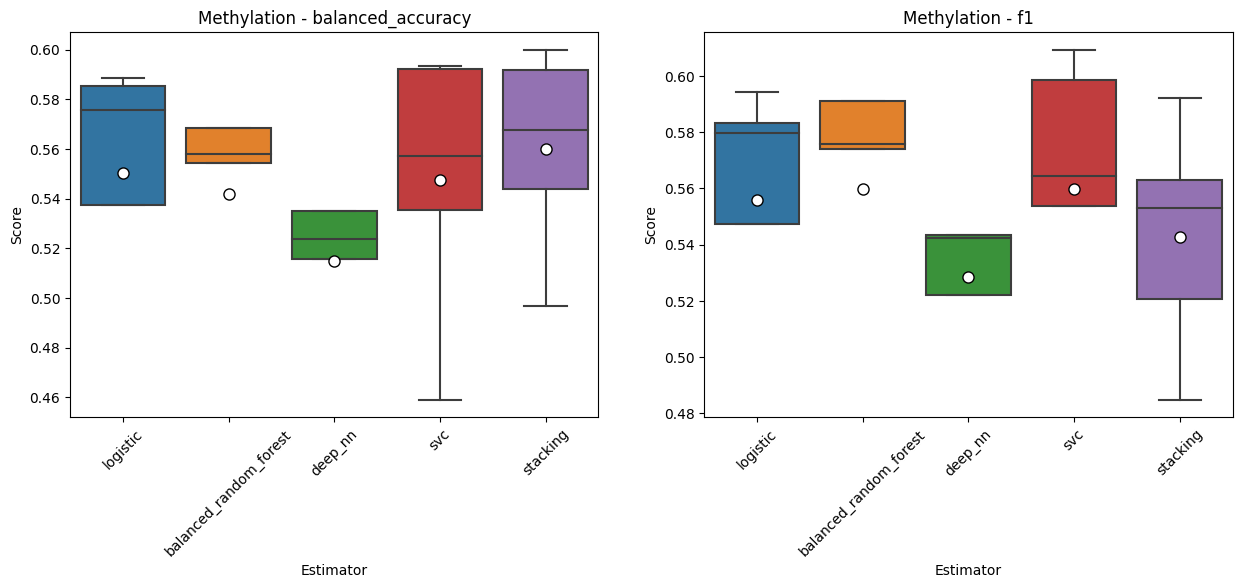

In [141]:
plot_box_scores(estimator_names, base_scores['methylation'], 'Methylation', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

In [142]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1, method='predict_proba')

  0%|          | 0/3 [00:00<?, ?it/s]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 33%|███▎      | 1/3 [08:11<16:22, 491.49s/it]/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (m

In [144]:
# Making dataframe of predicted class out of probabilities
preds_class_df = pd.DataFrame({
    'rna': preds['rna'].argmax(axis=1),
    'mirna': preds['mirna'].argmax(axis=1),
    'methylation': preds['methylation'].argmax(axis=1)
})

# Making dataframe of predicted probabilities
preds_proba_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna_0', 'rna_1', 'rna_2']), pd.DataFrame(preds['mirna'], columns=['mirna_0', 'mirna_1', 'mirna_2']), pd.DataFrame(preds['methylation'], columns=['meth_0', 'meth_1', 'meth_2'])], axis=1)

In [145]:
preds_class_df

,rna,mirna,methylation
0,1,0,0
1,0,1,0
2,1,0,1
3,0,0,0
4,0,0,0
...,...,...,...
472,0,0,0
473,0,0,0
474,0,0,0
475,0,0,0


In [157]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score

def calculate_voting_scores(preds_class_df, y, name):
    # Find the majority class for each sample
    majority_class = preds_class_df.mode(axis=1)[0]

    # Calculate the scores
    accuracy = accuracy_score(y, majority_class)
    balanced_accuracy = balanced_accuracy_score(y, majority_class)
    f1 = f1_score(y, majority_class, average='weighted')
    recall = recall_score(y, majority_class, average=None)

    # Create a DataFrame with the scores
    scores_df = pd.DataFrame({
        'accuracy': [accuracy],
        'balanced_accuracy': [balanced_accuracy],
        'f1': [f1],
        'recall (astro)': [recall[0]],
        'recall (oligoastro)': [recall[1]],
        'recall (oligodendro)': [recall[2]],
    })

    return scores_df.rename(index={0: name})

In [158]:
rna_mirna_meth = calculate_voting_scores(preds_class_df, y, 'rna_mirna_meth')
mirna_meth = calculate_voting_scores(preds_class_df[['mirna', 'methylation']], y, 'mirna_meth')
rna_meth = calculate_voting_scores(preds_class_df[['rna', 'methylation']], y, 'rna_meth')
rna_mirna = calculate_voting_scores(preds_class_df[['rna', 'mirna']], y, 'rna_mirna')

In [159]:
# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, rna_mirna_meth, mirna_meth, rna_meth, rna_mirna])
integration_voting_metrics

,accuracy,balanced_accuracy,f1,recall (astro),recall (oligoastro),recall (oligodendro)
rna,0.593 +/- 0.039,0.542 +/- 0.040,0.540 +/- 0.042,0.822 +/- 0.059,0.080 +/- 0.076,0.724 +/- 0.109
mirna,0.587 +/- 0.039,0.530 +/- 0.039,0.511 +/- 0.036,0.822 +/- 0.062,0.016 +/- 0.020,0.753 +/- 0.096
methylation,0.618 +/- 0.036,0.560 +/- 0.037,0.543 +/- 0.037,0.866 +/- 0.053,0.032 +/- 0.047,0.782 +/- 0.091
rna_mirna_meth,0.607966,0.547713,0.525422,0.899441,0.008065,0.735632
mirna_meth,0.610063,0.550959,0.532158,0.921788,0.024194,0.706897
rna_meth,0.616352,0.558305,0.544838,0.916201,0.040323,0.718391
rna_mirna,0.60587,0.5479,0.53358,0.921788,0.032258,0.689655


### Stacking

In [151]:
rna_mirna_meth_scores, rna_mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df, y, name='rna + mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'),'recall (astro)': make_scorer(recall_multiclass, label=0), 'recall (oligoastro)': make_scorer(recall_multiclass, label=1), 'recall (oligodendro)': make_scorer(recall_multiclass, label=2)})
mirna_meth_scores, mirna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['mirna_0', 'mirna_1', 'mirna_2', 'meth_0', 'meth_1', 'meth_2']], y, name='mirna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (astro)': make_scorer(recall_multiclass, label=0), 'recall (oligoastro)': make_scorer(recall_multiclass, label=1), 'recall (oligodendro)': make_scorer(recall_multiclass, label=2)})
rna_meth_scores, rna_meth_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_0', 'rna_1', 'rna_2', 'meth_0', 'meth_1', 'meth_2']], y, name='rna + methylation', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (astro)': make_scorer(recall_multiclass, label=0), 'recall (oligoastro)': make_scorer(recall_multiclass, label=1), 'recall (oligodendro)': make_scorer(recall_multiclass, label=2)})
rna_mirna_scores, rna_mirna_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_0', 'rna_1', 'rna_2', 'mirna_0', 'mirna_1', 'mirna_2']], y, name='rna + mirna', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (astro)': make_scorer(recall_multiclass, label=0), 'recall (oligoastro)': make_scorer(recall_multiclass, label=1), 'recall (oligodendro)': make_scorer(recall_multiclass, label=2)})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [152]:
integration_stacking_metrics = pd.concat([modality_metrics, rna_mirna_meth_df, mirna_meth_df, rna_meth_df, rna_mirna_df])

In [153]:
integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (astro),recall (oligoastro),recall (oligodendro)
rna,0.593 +/- 0.039,0.542 +/- 0.040,0.540 +/- 0.042,0.822 +/- 0.059,0.080 +/- 0.076,0.724 +/- 0.109
mirna,0.587 +/- 0.039,0.530 +/- 0.039,0.511 +/- 0.036,0.822 +/- 0.062,0.016 +/- 0.020,0.753 +/- 0.096
methylation,0.618 +/- 0.036,0.560 +/- 0.037,0.543 +/- 0.037,0.866 +/- 0.053,0.032 +/- 0.047,0.782 +/- 0.091
rna + mirna + methylation,0.633 +/- 0.038,0.571 +/- 0.039,0.545 +/- 0.038,0.922 +/- 0.048,0.016 +/- 0.020,0.776 +/- 0.107
mirna + methylation,0.627 +/- 0.034,0.566 +/- 0.032,0.540 +/- 0.024,0.905 +/- 0.054,0.016 +/- 0.020,0.776 +/- 0.107
rna + methylation,0.627 +/- 0.035,0.565 +/- 0.033,0.537 +/- 0.024,0.911 +/- 0.048,0.008 +/- 0.017,0.776 +/- 0.101
rna + mirna,0.612 +/- 0.031,0.551 +/- 0.031,0.521 +/- 0.027,0.906 +/- 0.067,0.000 +/- 0.000,0.747 +/- 0.096


In [154]:
names = ['rna', 'mirna', 'methylation', 'rna + mirna + meth', 'mirna + meth', 'rna + meth', 'rna + mirna']
integration = []
integration.append(scores['rna'])
integration.append(scores['mirna'])
integration.append(scores['methylation'])
integration.append(rna_mirna_meth_scores)
integration.append(mirna_meth_scores)
integration.append(rna_meth_scores)
integration.append(rna_mirna_scores)

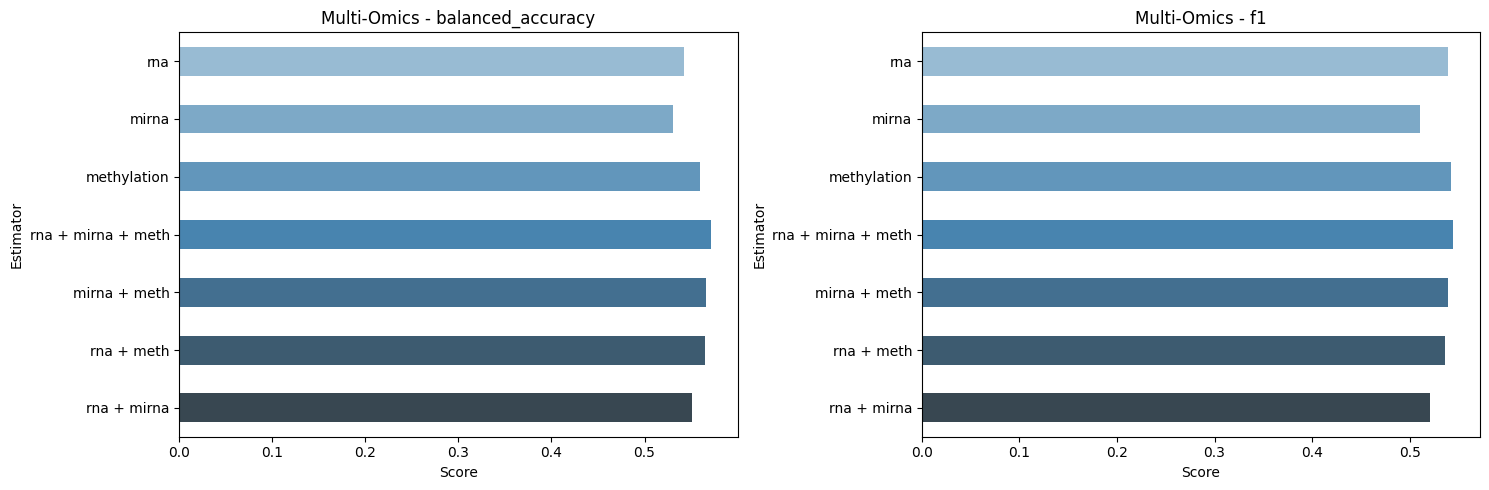

In [155]:
plot_bar_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

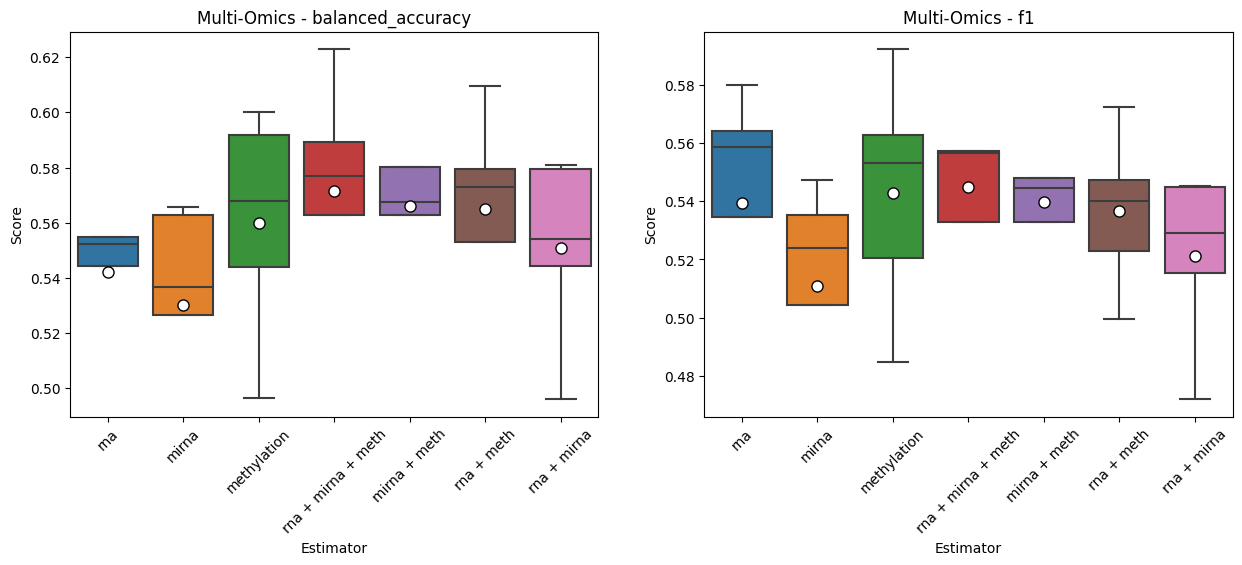

In [156]:
plot_box_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])